In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from qiskit.visualization.bloch import Bloch
from qiskit.visualization import plot_bloch_vector
from sympy.physics.matrices import msigma
from sympy.physics.quantum.dagger import Dagger
from sympy import Matrix
from sympy import I, N, re, exp, sin, cos, pi, eye
import numpy as np

In [2]:
def to_spherical(vec):
    x = np.real(vec[0])
    y = np.real(vec[1])
    z = np.real(vec[2])
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    ϕ = np.arctan2(y, x) #az
    θ = np.arctan2(hxy, z) #el
    return [r, ϕ, θ]

def to_cartesian(polar):
    r = polar[0]
    ϕ = polar[1]
    θ = polar[2]

    x = r * np.sin(θ) * np.cos(ϕ)
    y = r * np.sin(θ) * np.sin(ϕ)
    z = r * np.cos(θ)
    return [np.real(x), np.real(y), np.real(z)]

In [3]:
# taken from Jean-Marie Normand: A Lie Group: Rotations in Quantum Mechanics (p. 67)
# and equivalently https://link.springer.com/content/pdf/bbm%3A978-3-540-29082-7%2F1.pdf
def rn_su2_euler(vec, rx, ry, rz):
    spherical_vec = to_spherical(vec)
    ϕ = spherical_vec[1]
    θ = spherical_vec[2]

    # https://www.phys.hawaii.edu/~yepez/Spring2013/lectures/Lecture1_Qubits_Notes.pdf (p. 3)
    sx = msigma(1)
    sy = msigma(2)
    sz = msigma(3)
    M_q = (np.sin(θ)*np.cos(ϕ)*sx + np.sin(θ)*np.sin(ϕ)*sy + np.cos(θ)*sz)
    U_n = Matrix([[exp(-I*(rx+rz)/2)*cos(ry/2), -exp(-I*(rx-rz)/2)*sin(ry/2)], [exp(I*(rx-rz)/2)*sin(ry/2), exp(I*(rx+rz)/2)*cos(ry/2)]])
    M_q_rotated = U_n*M_q*Dagger(U_n)
    return M_q_rotated

In [4]:
def extract_angles(M_q_rotated):
    cos_θ_rotated = float(N(re(M_q_rotated[0,0])))
    θ_rotated = np.arccos(cos_θ_rotated)
    
    #e^(ix) = cos(x) + i*sin(x), see https://en.wikipedia.org/wiki/Euler%27s_identity
    temp = float(N(re(M_q_rotated[1,0])))
    temp = temp/np.sin(θ_rotated)
    ϕ_rotated = np.arccos(temp)
    return (ϕ_rotated, θ_rotated)

In [5]:
def get_gradient_colors(rgb, n):
    red=rgb[0] 
    yel=rgb[1]
    blu=rgb[2]
    result = [colors.to_hex([red,yel,blu])]
    cr = red/n
    cy = yel/n
    cb = blu/n
    for i in range(n):
        if(red!=0):
            red -= cr 
        if(yel!=0):
            yel -= cy
        if(blu!=0):
            blu -= cb
        result.append(colors.to_hex([red,yel,blu]))
    return result

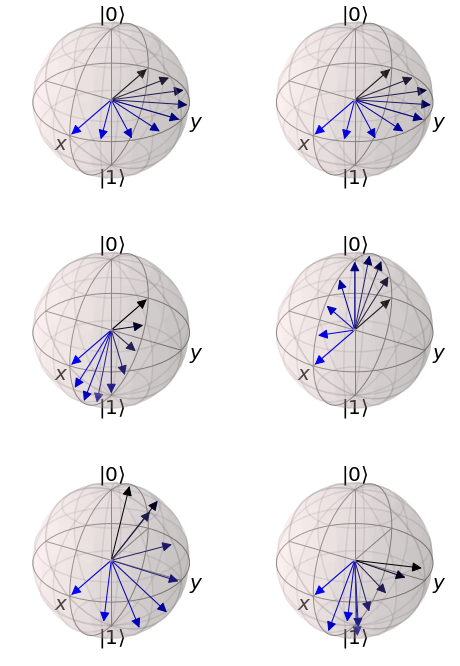

In [6]:
fig, ax = plt.subplots(figsize = [8, 12], nrows=3, ncols=2)
fig.patch.set_facecolor('white')
[axis.set_axis_off() for axis in ax.ravel()]

rotations = [[0, 0, pi/8], [0, 0, pi/8], [0, pi/8, 0], [0.00001, -pi/8, 0], [0, pi/8, pi/8], [0, pi/8, -pi/8]]
start_vec = [1, 0, 0]
num_iterations = 8

for m, rotation in enumerate(rotations):
    ax = fig.add_subplot(320+(m+1), axes_class = Axes3D)
    
    rot_x = rotation[0]
    rot_y = rotation[1]
    rot_z = rotation[2]
    _bloch = Bloch(axes=ax)
    _bloch.vector_color = get_gradient_colors([0, 0, 1], num_iterations)
    _bloch.vector_width = 1
    sv = []
    vec = start_vec
    sv.append(vec)
    for i in range(num_iterations):
        M_q_rotated = rn_su2_euler(vec, rot_x, rot_y, rot_z)
        (ϕ_rotated, θ_rotated) = extract_angles(M_q_rotated)
        vec = np.array(to_cartesian([1, ϕ_rotated, θ_rotated]))
        sv.append(vec)

    _bloch.add_vectors(sv)
    _bloch.render()   